http://nadbordrozd.github.io/blog/2016/05/20/text-classification-with-word2vec/  
https://machinelearningmastery.com/develop-word-embedding-model-predicting-movie-review-sentiment/

In [176]:
import multiprocessing
import os
import pickle
import re
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from collections import defaultdict
from gensim.models import Word2Vec

from nltk import sent_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, wordpunct_tokenize

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import ExtraTreesClassifier, AdaBoostClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

from xgboost import XGBClassifier

In [2]:
probs = pd.read_csv('../data/textbook-problems.csv')
probs.reset_index(drop=True)
probs.head()

,filepath,number,text,txt,balancing,e_config
0,bauer-5,1,Consider the following molecular-level diagram...,"['consider', 'following', 'diagrams', 'chemica...",0,0
1,bauer-5,2,Consider the following molecular-level diagram...,"['consider', 'following', 'diagrams', 'chemica...",0,0
2,bauer-5,3,Balance the following chemical equations. Clas...,"['balance', 'following', 'chemical', 'equation...",1,0
3,bauer-5,4,Balance the following equations and classify t...,"['balance', 'following', 'equations', 'classif...",1,0
4,bauer-5,5,"When heated, nickel(II) carbonate undergoes a ...","['when', 'heated', 'nickel', 'ii', 'carbonate'...",1,0


In [3]:
probs['e_config'] = probs['e_config'] * 2
probs['e_config'].value_counts()

0    469
2     53
Name: e_config, dtype: int64

In [4]:
probs['target'] = probs['balancing'] + probs['e_config']
probs['target'].value_counts()

0    348
1    121
2     53
Name: target, dtype: int64

In [5]:
probs.isna().sum()

filepath     0
number       0
text         0
txt          0
balancing    0
e_config     0
target       0
dtype: int64

In [134]:
probs.shape

(522, 7)

In [173]:
max_length = max([len(s.split()) for s in X])

In [177]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [181]:
E_train = tokenizer.texts_to_sequences(X_train)
E_test = tokenizer.texts_to_sequences(X_test)

In [182]:
Z_train = pad_sequences(E_train, maxlen=max_length, padding='post')
Z_test = pad_sequences(E_test, maxlen=max_length, padding='post')

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size=0.5,
                                                    stratify=y, 
                                                    random_state=111)

In [9]:
X_train.shape

(261,)

In [10]:
y_train.shape

(261,)

In [11]:
y_train.value_counts(normalize=True)

0    0.666667
1    0.229885
2    0.103448
Name: target, dtype: float64

In [35]:
y_train = utils.to_categorical(y_train, 3)
y_test = utils.to_categorical(y_test, 3)

In [144]:
model = pickle.load(open('../model/model.p', 'rb'))
w2v = pickle.load(open('../model/w2v.p', 'rb'))

In [129]:
len(model.wv['solution'])

100

In [167]:
# https://stackoverflow.com/questions/57525190/

words = list(model.wv.vocab)
EMB_DIM = 100

vocab_size = len(words) + 1
embedding_matrix = np.zeros((vocab_size, EMB_DIM))
for i, word in enumerate(words):
    vector = model.wv[word]
    if vector is not None:
        embedding_matrix[i] = vector

In [83]:
list(model.wv.vocab.items())

('chemistry', <gensim.models.keyedvectors.Vocab at 0x1a46151128>)

## using neural networks

In [147]:
tf = TfidfEmbeddingVectorizer(w2v)

In [149]:
T_train = tf.fit_transform(X_train)
T_test = tf.transform(X_test)

In [169]:
nn = Sequential()
nn.add(Embedding(input_dim=vocab_size,
#                  input_length=max_length, 
                 output_dim=EMB_DIM, 
                 weights=[embedding_matrix]))
nn.add(Dense(3, activation='softmax'))
nn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

In [183]:
hist = nn.fit(Z_train, y_train, epochs=10, batch_size=32,
                 validation_data=(Z_test, y_test))

Train on 261 samples, validate on 261 samples
Epoch 1/10
 32/261 [==>...........................] - ETA: 5s

InvalidArgumentError:  Incompatible shapes: [32] vs. [32,77]
	 [[node metrics/acc/Equal (defined at /Users/Jelly/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/ops.py:1751) ]] [Op:__inference_distributed_function_6018]

Function call stack:
distributed_function


## transformer classes

In [138]:
class MeanEmbeddingVectorizer(BaseEstimator, TransformerMixin):
    
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = len(self.word2vec.items())

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

In [139]:
class TfidfEmbeddingVectorizer(BaseEstimator, TransformerMixin):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.word2weight = None
        self.dim = len(word2vec.items())

    def fit(self, X, y=None):
        self.tfidf = TfidfVectorizer().fit(X)
        # if a word was never seen - it must be at least as infrequent
        # as any of the known words - so the default idf is the max of 
        # known idf's
        max_idf = max(self.tfidf.idf_)
        self.word2weight = defaultdict(
            lambda: max_idf,
            [(w, self.tfidf.idf_[i]) for w, i in self.tfidf.vocabulary_.items()])

        return self

    def transform(self, X, y=None):
        return np.array([
                np.mean([self.word2vec[w] * self.word2weight[w]
                         for w in words if w in self.word2vec] or
                        [np.zeros(self.dim)], axis=0)
                for words in X
            ])

In [15]:
etree_w2v_tfidf = Pipeline([
    ("word2vec vectorizer", TfidfEmbeddingVectorizer(model.wv)),
    ("extra trees", ExtraTreesClassifier(n_estimators=100))])

In [16]:
etree_w2v_tfidf.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('word2vec vectorizer',
                 <__main__.TfidfEmbeddingVectorizer object at 0x1a419d1a90>),
                ('extra trees',
                 ExtraTreesClassifier(bootstrap=False, class_weight=None,
                                      criterion='gini', max_depth=None,
                                      max_features='auto', max_leaf_nodes=None,
                                      min_impurity_decrease=0.0,
                                      min_impurity_split=None,
                                      min_samples_leaf=1, min_samples_split=2,
                                      min_weight_fraction_leaf=0.0,
                                      n_estimators=100, n_jobs=None,
                                      oob_score=False, random_state=None,
                                      verbose=0, warm_start=False))],
         verbose=False)

In [18]:
y_hat = etree_w2v_tfidf.predict(X_test)

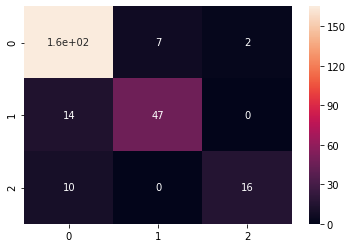

In [19]:
matrix = confusion_matrix(y_test, y_hat)
sns.heatmap(matrix, annot=True)

In [20]:
etree_w2v_tfidf.score(X_test, y_test)

0.8735632183908046

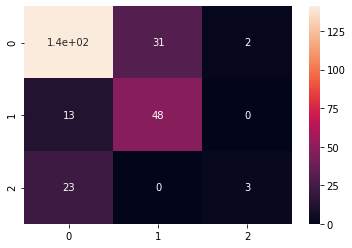

In [22]:
ada_w2v_tfidf = Pipeline([
    ("word2vec vectorizer", TfidfEmbeddingVectorizer(w2v)),
    ("ada_boost", AdaBoostClassifier(n_estimators=100))])

ada_w2v_tfidf.fit(X_train, y_train)
y_hat = ada_w2v_tfidf.predict(X_test)

matrix = confusion_matrix(y_test, y_hat)
sns.heatmap(matrix, annot=True)

In [24]:
ada_w2v_tfidf.score(X_test, y_test)

0.735632183908046

In [33]:
tf = TfidfEmbeddingVectorizer(w2v)
T = tf.fit_transform(X)
T.shape

(522, 300)

In [ ]:
X_train.shape

In [36]:
y_train.shape

(261, 3)

In [46]:
def model_function(neurons_1=64, neurons_2=32):
    model = Sequential()                   
    model.add(Dense(units=neurons_1,                    
                    activation='relu',   
                    input_shape=(300,)))
    model.add(Dense(units=neurons_2,
                    activation='relu'))
    model.add(Dense(units=y_train.shape[-1],
                    activation='softmax'))
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['acc'])
    return model

In [54]:
nn_w2v_tfidf = Pipeline([
    ("w2v", TfidfEmbeddingVectorizer(w2v)),
    ("nn", KerasClassifier(build_fn=model_function,
                           batch_size=32,
                           verbose=1))
])

In [55]:
params = {
    'epochs': [10]
}

In [56]:
grid = GridSearchCV(nn_w2v_tfidf, param_grid=params, cv=2)

In [57]:
grid.fit(X_train, y_train)
print(grid.best_score_)
print(grid.best_params_)

KeyboardInterrupt: 